In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
in_folder = '../data/processed/6_new/'

In [23]:
train_data_path = in_folder + 'train.csv'
train_df = pd.read_csv(train_data_path)

test_data_path = in_folder + 'test.csv'
test_df = pd.read_csv(test_data_path)

final_train_data_path = in_folder + 'final_train.csv'
final_train_df = pd.read_csv(final_train_data_path)

predictive_data_path = in_folder + 'predictive.csv'
predictive_df = pd.read_csv(predictive_data_path)

price_bins = [0, 1, 2, 3, 4, 5]

X_train = train_df.drop('price', axis=1)
y_train = train_df['price']
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']
X_final_train = final_train_df.drop('price', axis=1)
y_final_train = final_train_df['price']
X_predictive = predictive_df.drop('id', axis=1)
id_predictive = predictive_df['id']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_scaler = StandardScaler()

X_final_train_scaled = final_scaler.fit_transform(X_final_train)
X_predictive_scaled = final_scaler.transform(X_predictive)


def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):

    y_train_pred = np.round(model.predict(X_train))
    y_train_pred = np.clip(y_train_pred, 0, 5)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    y_test_pred = np.round(model.predict(X_test))
    y_test_pred = np.clip(y_test_pred, 0, 5)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    print(f"--- {model_name} Performance ---")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    cm = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm, classes=[0,1,2,3,4,5], title=f'Confusion Matrix: {model_name}')

In [24]:
best_params = {'n_estimators': 1250, 'max_depth': 18, 'learning_rate': 0.009672322857709447, 'subsample': 0.5995733414930916, 'colsample_bytree': 0.7015355269694935, 'gamma': 0.09414477803815322, 'min_child_weight': 14, 'reg_alpha': 0.11634462235072016, 'reg_lambda': 2.9763208571932926}

--- XGBoost Performance ---
Train RMSE: 0.2268
Test RMSE: 0.7917


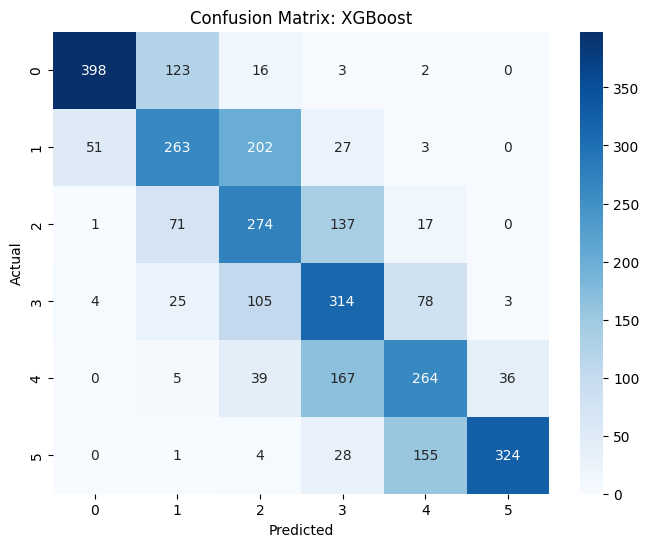

In [25]:
best_xgb = XGBRegressor(random_state=314, **best_params)
best_xgb.fit(X_train, y_train)
evaluate_model(best_xgb, X_train, y_train, X_test, y_test, 'XGBoost')

In [26]:
final_xgb = XGBRegressor(random_state=314, **best_params)
final_xgb.fit(X_final_train, y_final_train)
final_predictions = final_xgb.predict(X_predictive)
final_predictions = np.round(final_predictions).astype(int)
final_predictions = np.clip(final_predictions, 0, 5)

out_folder = '../data/processed/'
submission = pd.DataFrame({'id': id_predictive, 'price': final_predictions})
submission.to_csv(out_folder + 'xgboost.csv', index=False)

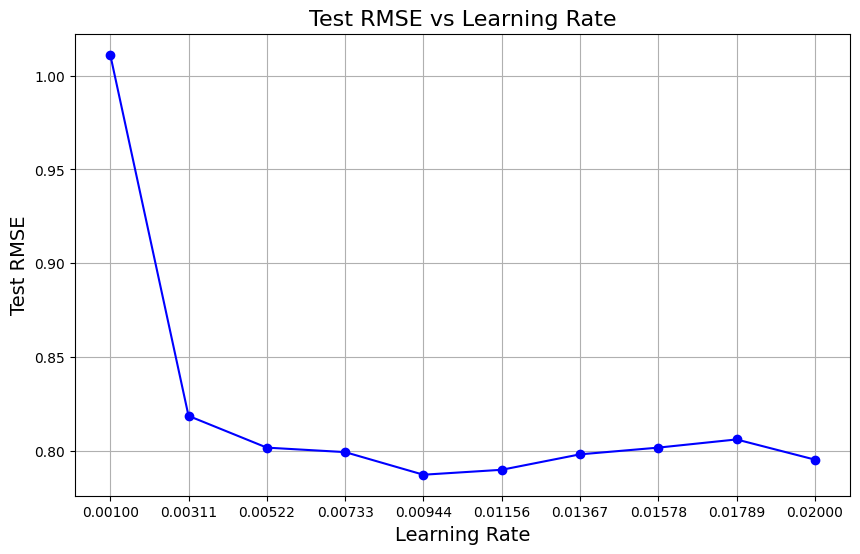

In [27]:
learning_rates = np.linspace(0.001, 0.02, 10)
rmse_values = []

for lr in learning_rates:
    params = best_params.copy()
    params['learning_rate'] = lr
    xgb = XGBRegressor(random_state=314, **params)
    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)
    y_pred = np.round(y_pred).astype(int)
    y_pred = np.clip(y_pred, 0, 5)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('Test RMSE', fontsize=14)
plt.title('Test RMSE vs Learning Rate', fontsize=16)
plt.grid(True)
plt.xticks(learning_rates)
plt.show()

C:\Users\Samu\AppData\Local\Temp\ipykernel_30764\1770458132.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


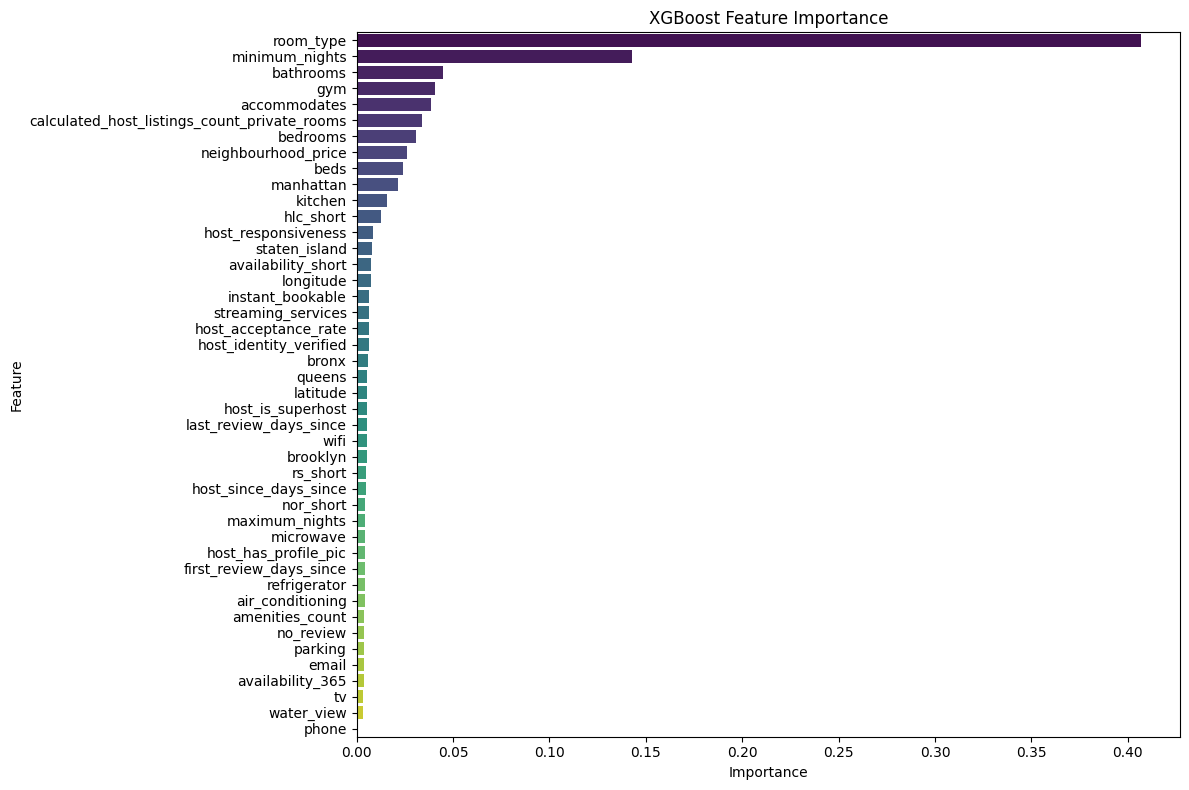

In [28]:
feature_importances = final_xgb.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()